In [1]:
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import os
import mytools

# Data Handling

In [2]:
# Make custom dataset
num_sims = int((len(os.listdir('/home/majd/sparse_tensors/'))-1)/3) # -1 because I noticed a .DS_store file was added, /3 
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_tensors/', N_sims=num_sims)

# Split datat into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(MyDataset,[0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))

print("Training samples: ", len(train_dataset))
print("Validation samples: ", len(val_dataset))
print("Testing samples: ", len(test_dataset))

# Create DataLoaders
batch_size = 200
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Training samples:  480713
Validation samples:  160238
Testing samples:  160237


In [3]:
# Print tensor shapes
for X_plot, y_plot, idx in train_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("indices: ", idx.shape)
    break


Shape of X [N, C, H, W, D]: torch.Size([200, 1, 120, 120, 120])
Shape of y: torch.Size([200, 3]) torch.float32
indices:  torch.Size([200])


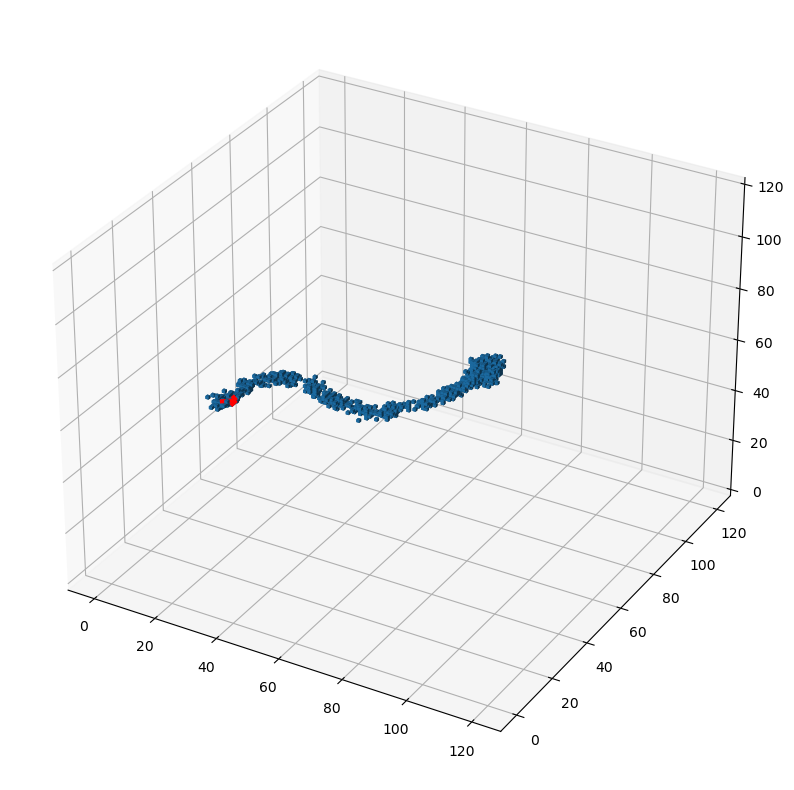

In [4]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = 3.0
# Voxel size in cm
vox_l = 0.05

index = 4
off = torch.load('/home/majd/sparse_tensors/' + 'offset_' + str(idx[index].item()) + '.pt' )
mytools.plot_tensor_dir(tensor = X_plot.to_dense().numpy()[index], start = off, direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)

# Define Convnet Architecture

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1)
        self.conv3 = nn.Conv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(12**3 *20, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = F.normalize(self.fc3(x),dim=1)
        return x

model = NeuralNetwork().to(device)

# Print a nicer model summary
print(model)

Using cuda device
NeuralNetwork(
  (conv1): Conv3d(1, 50, kernel_size=(6, 6, 6), stride=(2, 2, 2))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(50, 30, kernel_size=(4, 4, 4), stride=(1, 1, 1))
  (conv3): Conv3d(30, 20, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (fc1): Linear(in_features=34560, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
)


# Train the model

In [6]:
# Specify optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001, betas=(0.94, 0.999), eps=1e-07)

# Define Loss function
CS = nn.CosineSimilarity()
def loss_fn(output, target):
    loss = torch.mean(-1.0*CS(output,target))
    return loss

In [9]:
# Implement early stopping in training loop
# Stop if validation loss has not decreased for the last [patience] epochs
# The model with the lowest loss is stored
patience = 2

Training_losses = np.array([])
Validation_losses = np.array([])

epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    Training_losses = np.append(Training_losses, mytools.train(train_dataloader, model, loss_fn, optimizer, device))
    Validation_losses = np.append(Validation_losses, mytools.validate(val_dataloader, model, loss_fn, device))
    
    # Keep a running copy of the model with the lowest loss
    if Validation_losses[-1] == np.min(Validation_losses):
        final_model = copy.deepcopy(model)
    
    if len(Validation_losses) > patience:
        if np.sum((Validation_losses[-1*np.arange(patience)-1] - Validation_losses[-1*np.arange(patience)-2]) < 0) == 0:
            print("Stopping early!")
            break
            
print("Done!")

Epoch 1
-------------------------------
Current batch training loss: -0.045868  [    0/480713]
Current batch training loss: -0.374688  [20000/480713]
Current batch training loss: -0.383638  [40000/480713]
Current batch training loss: -0.442997  [60000/480713]
Current batch training loss: -0.522473  [80000/480713]
Current batch training loss: -0.505778  [100000/480713]
Current batch training loss: -0.609915  [120000/480713]
Current batch training loss: -0.685657  [140000/480713]
Current batch training loss: -0.718919  [160000/480713]
Current batch training loss: -0.712454  [180000/480713]
Current batch training loss: -0.744635  [200000/480713]
Current batch training loss: -0.755896  [220000/480713]
Current batch training loss: -0.706344  [240000/480713]
Current batch training loss: -0.748825  [260000/480713]
Current batch training loss: -0.798311  [280000/480713]
Current batch training loss: -0.834065  [300000/480713]
Current batch training loss: -0.849003  [320000/480713]
Current batch

# Evaluating Performance

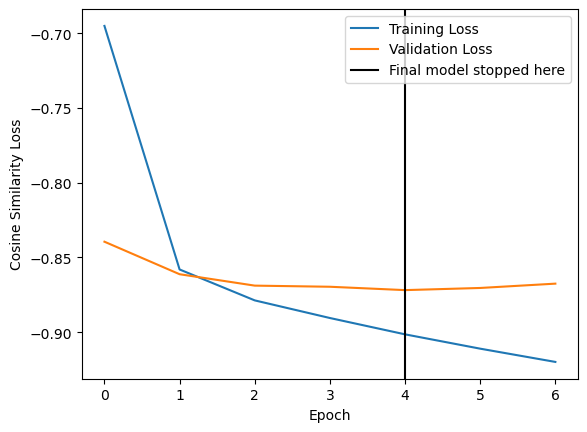

In [10]:
# Plot Training and Validation Loss
# Indicate where the final model stopped training

best_epoch = np.argmin(Validation_losses)

plt.plot(np.arange(len(Training_losses)),Training_losses,label="Training Loss")
plt.plot(np.arange(len(Validation_losses)),Validation_losses,label="Validation Loss")
plt.axvline(best_epoch,label="Final model stopped here",color='k')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity Loss')
plt.legend()


# Save the Model

In [11]:
torch.save(final_model.state_dict(), "../3D_Heteroscedastic_Convnet_models/3D_CNN.pth")
print("Saved PyTorch Model State to ../3D_Heteroscedastic_Convnet_models/3D_CNN.pth")

Saved PyTorch Model State to 3D_CNN.pth
